# Project Motivation
With the rise of telederm, users upload a photo of their face to aid dermatologists in the assessment. They then count and determine the type of every acne. However, this process is labour intensive, prone to bias and does not scale well. Hence, being able to identify the type of acne found on the face using computer vision, this creates room for automated acne diagnosis. Alternatively, in recommendation systems for skincare products on ecommerce sites, this data can empower the algorithms behind by acting as an additional source of information to recommend specific products which would be ideal to remedy the acne.

# Project Description
Using our learning model, users can take a photo of themselves and upload it. We will then segment the photo into windows and let the model classify the type of acne. With the output classification, we will then determine the count of every acne type on users’ faces. This will then provide the dermatologist with data to determine the best course of action for the user.

# Steps

## 1. Data Scraping
For our dataset, we will be scraping acne images from https://dermnetnz.org/. This section loops through `img` tag of the gallery using BeautifulSoup library and downloads them.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import shutil

def download_image(image_url, image_name):
    url = image_url
    response = requests.get(url, stream=True)
    with open(image_name, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response

In [2]:
def scrape_dermnet(url):
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    textBlock = soup.find('section', class_="textBlock")
    imgs = textBlock.findAll('img')
    img_dataset = pd.DataFrame([[img.attrs['alt'], "https://dermnetnz.org/" + img.attrs['data-src']] for img in imgs], columns=['alt', 'image_url'])
    img_dataset['image_name'] = [f'scraped_data/image_{e}.jpg' for e in range(img_dataset.shape[0])]
    return img_dataset

In [3]:
# Download images
img_dataset = scrape_dermnet("https://dermnetnz.org/topics/acne-face-images")
import os
print(os.getcwd())
!mkdir -p scraped_data
for row in img_dataset.itertuples():
    print(row)
    download_image(row.image_url, row.image_name)

/content
Pandas(Index=0, alt='Folliculitis', image_url='https://dermnetnz.org//assets/Uploads/acne/folliculitis/2652__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDBd.jpg', image_name='scraped_data/image_0.jpg')
Pandas(Index=1, alt='Perioral acne', image_url='https://dermnetnz.org//assets/Uploads/acne-039-v2__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.JPG', image_name='scraped_data/image_1.jpg')
Pandas(Index=2, alt='Perioral acne', image_url='https://dermnetnz.org//assets/Uploads/acne-077-v2__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.JPG', image_name='scraped_data/image_2.jpg')
Pandas(Index=3, alt='Perioral acne', image_url='https://dermnetnz.org//assets/Uploads/acne-089-v2__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.JPG', image_name='scraped_data/image_3.jpg')
Pandas(Index=4, alt='Perioral acne', image_url='https://dermnetnz.org//assets/Uploads/acne-187-v2__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.JPG', image_name='scraped_data/image_4.jp

# New section

253 images were successfully scraped.

## 1.1 Sliding Window

As each facial image may contain multiple acne of different acne types, it will be best to break it into smaller patches to aid with the counting. We will construct a sliding window of size 50 x 50 and stride 50, iterating across each image to generate patches.

In [4]:
from os import listdir, rename
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random

In [5]:
images = [join('scraped_data', f) for f in listdir('scraped_data') if isfile(join('scraped_data', f))]

In [6]:
# Set size of sliding window
window_size = 50

In [7]:
# Slicing images
import os
print(os.getcwd())
!mkdir -p temp_dataset
counter = 0
for image_path in images:
    img = np.asarray(Image.open(image_path))
    for i in range(0,img.shape[0],window_size):
        for j in range(0,img.shape[1],window_size):
            sub_img = img[i:i+window_size, j:j+window_size, :]
            # Save image
            img_name = image_path.split('/')[-1].split('.')[0]
            Image.fromarray(sub_img).save(f'temp_dataset/{counter}.jpg')
            counter += 1

/content


In [8]:
# Create csv for tagging
cropped_images = sorted([f for f in listdir('temp_dataset') if isfile(join('temp_dataset', f))])
shuffled_images_name = cropped_images.copy()
random.shuffle(shuffled_images_name)
filenames_rows = list(zip(cropped_images, shuffled_images_name))

In [9]:
tagging_df = pd.DataFrame(filenames_rows, columns=['Image File', 'New Image Name'])

In [10]:
# Rename files with shuffled names
# print(os.getcwd())
!mkdir -p dataset
for idx, row in tagging_df.iterrows():
    rename(f'temp_dataset/{row["Image File"]}', f'dataset/{row["New Image Name"]}')

In [11]:
tagging_df.head()

,Image File,New Image Name
0,0.jpg,124.jpg
1,1.jpg,7284.jpg
2,10.jpg,5118.jpg
3,100.jpg,5423.jpg
4,1000.jpg,6616.jpg


In [12]:
tagging_df.to_csv('original_filename.csv', index=False)

Through this process, we generated approximately 7,500 patches. We then manually labelled 1,500 patches as our dataset to split into train and test later on. These patches were labelled as one of these 6 classes:
- Not face - 0
- Normal skin - 1
- Pustule - 2
- Whitehead - 3
- Blackhead - 4
- Cyst - 5


# Getting Label

In [13]:
import pandas as pd

# !wget "https://raw.githubusercontent.com/simasuiyuan/CS5242/zhunhung_dev/labels.csv"
!wget "https://raw.githubusercontent.com/simasuiyuan/CS5242/master/labels.csv"
labels = pd.read_csv('labels.csv')

--2021-11-18 03:45:07--  https://raw.githubusercontent.com/simasuiyuan/CS5242/master/labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20355 (20K) [text/plain]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]  19.88K  --.-KB/s    in 0s      

2021-11-18 03:45:07 (51.9 MB/s) - ‘labels.csv’ saved [20355/20355]



## 2. Data Exploration and Preprocessing

In [14]:
# from project.src.dataLoader import dataLoader
from abc import ABC, abstractclassmethod
import pathlib
import imghdr
import os
from typing import Union, Tuple, List, Callable, Any, Dict

class dataLoaderABC(ABC):
    @abstractclassmethod
    def __init__(self, file_directory: Union[str, pathlib.Path, os.DirEntry], fileType: str='image'):
        self.fileType = fileType if fileType in ["image", 'csv', 'excel'] else None
        self.file_directory: Union[str, pathlib.Path, os.DirEntry] = file_directory
        self.file_list: List[pathlib.Path] = []
        self.file_filter: Callable = lambda: True

    @abstractclassmethod
    def LoadFileList(self, file_type:str=None) -> List[pathlib.Path]:
        pass

    @abstractclassmethod
    def check_file_is_image(
        self,
        file_path: Union[str, pathlib.Path, os.DirEntry],
        footer: Union[str, List[str], Tuple[str]]=None
    ) -> bool:
        pass


class dataLoader(dataLoaderABC):
    def __init__(self,file_directory: Union[str, pathlib.Path, os.DirEntry]):
        super().__init__(file_directory)
    
    def LoadFileList(self, file_type:str=None, fileNameList:List=None) -> List[pathlib.Path]:
        dir_path = pathlib.Path(self.file_directory)
        if not dir_path.is_dir():
            raise TypeError(f'Not a valid directory: {dir_path}')
        
        if self.fileType is not None:  
            if self.fileType == "image": self.file_filter = self.check_file_is_image
        
        if fileNameList is None:
            self.file_list = [
                pathlib.Path(file) for file in os.scandir(dir_path) if self.file_filter(file)
            ]
        else:
            for fileName in fileNameList:
                file_path = pathlib.Path(dir_path) / fileName
                if file_path.exists() and self.file_filter(file_path):
                    self.file_list.append(file_path)
        return self.file_list

    def check_file_is_image(
        self,
        file_path: Union[str, pathlib.Path, os.DirEntry],
        footer: Union[str, List[str], Tuple[str]]='jpg'
    ) -> bool:
        if not pathlib.Path(file_path).is_file():
            return False
        file_type = imghdr.what(file_path)
        if file_type is None:
            return False
        if footer is not None:
            return pathlib.Path(file_path).name.lower().endswith(footer)
        return True

In [15]:
# from project.src.utils import image_utils
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, Tuple, List, Callable, Any, Dict
import cv2

def ismember(A, B):
    return [np.sum(a == B) for a in A ]


class image_utils():
    def __init__(self):
        self.is_gray: bool=True

    def plot_image(
        self,
        image: np.ndarray,
        title: str = "",
        figsize: tuple = (10, 10),
    ) -> None:
        plt.close()
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        if self.is_gray:     
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)
        plt.title(title, fontsize=10)
        plt.show()
        plt.close()

    def get_image(
        self,
        file_path: Union[str, pathlib.Path],
        image_scale: int = cv2.COLOR_BGR2RGB,
        is_gray=False,
        cmap_type:str=None
    ) -> np.ndarray:
        pathlib.Path(file_path)
        self.is_gray = is_gray
        image = cv2.imread(file_path.as_posix())
        image = cv2.cvtColor(image, image_scale)
        # if self.is_gray:
        #     image = cv2.imread(file_path.as_posix(), cv2.IMREAD_GRAYSCALE)
        # else:
        #     image = cv2.imread(file_path.as_posix())
        #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def show_prob_pimples(self, p):
        p=p.data.squeeze().numpy()
        ft=15
        label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)
        #p=p.data.squeeze().numpy()
        y_pos = np.arange(len(p))*1.2
        target=2
        width=0.9
        col= 'blue'
        #col='darkgreen'

        plt.rcdefaults()
        fig, ax = plt.subplots()

        # the plot
        ax.barh(y_pos, p, width , align='center', color=col)

        ax.set_xlim([0, 1.3])
        #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

        # y label
        ax.set_yticks(y_pos)
        ax.set_yticklabels(label, fontsize=ft)
        ax.invert_yaxis()  
        #ax.set_xlabel('Performance')
        #ax.set_title('How fast do you want to go today?')

        # x label
        ax.set_xticklabels([])
        ax.set_xticks([])
        #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
        #ax.set_xticks(x_pos)
        #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_linewidth(4)


        for i in range(len(p)):
            str_nb="{0:.4f}".format(p[i])
            ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                    horizontalalignment='left', verticalalignment='center',
                    transform=ax.transData, color= col,fontsize=ft)



        plt.show()

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# from PIL import Image

from keras.preprocessing.image import load_img 
from keras.applications.vgg16 import preprocess_input 

from os import listdir, rename
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

%load_ext autoreload
%autoreload
# from project.src.dataLoader import dataLoader
# from project.src.utils import image_utils

In [17]:
def load_images(labels):
    X = []
    y = []
    for row in labels.itertuples():
        img_path = join('./dataset', row.filename)
        # print(row.filename)
        # print(img_path)
        # img = np.asarray(Image.open(img_path))
        # img = np.array(img) 
        img = load_img(img_path, target_size=(50,50))
        img = np.asarray(img)
        # Keep squares for now
        if img.shape[0] == img.shape[1]:
            y.append(row.label)
            X.append(img)
    return X, y

In [18]:
def augment_data_no_dist_balance(X_train, y_train):
    final_X_train = []
    final_y_train = []
    label_distribution = Counter(y_train)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    print(label_distribution)
    for i in range(len(X_train)):
        final_X_train.append(X_train[i])
        final_X_train.append(rotate(X_train[i], angle=45, mode = 'wrap'))
        final_X_train.append(np.fliplr(X_train[i]))
        final_X_train.append(np.flipud(X_train[i]))
        final_X_train.append(random_noise(X_train[i],var=0.05**2))
        
        final_y_train += [y_train[i]] * 5
    label_distribution = Counter(final_y_train)
    print(label_distribution)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    return final_X_train, final_y_train

def augment_data(X_train, y_train):
    final_X_train = []
    final_y_train = []
    label_distribution = Counter(y_train)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    print(label_distribution)
    max_count_label = max(label_distribution, key=label_distribution.get)
    min_count_label = min(label_distribution, key=label_distribution.get)
    for i in range(len(X_train)):
        label_key = y_train[i]
        if label_distribution[max_count_label] - label_distribution[label_key] >= 10 or label_distribution[max_count_label] - label_distribution[min_count_label] <= 6:
            final_X_train.append(X_train[i])
            angle = 90
            while angle < 360:
                final_X_train.append(rotate(X_train[i], angle=angle, mode = 'wrap'))
                angle+=90
            
            final_X_train.append(random_noise(X_train[i],var=0.05**2))
        
            final_y_train += [y_train[i]] * 5
            label_distribution = Counter(final_y_train)
            max_count = max(label_distribution, key=label_distribution.get)
            min_count = min(label_distribution, key=label_distribution.get)
    print(label_distribution)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    return final_X_train, final_y_train

In [19]:
labels = pd.read_csv('labels.csv')
display(labels.head())
labels.shape

,filename,label
0,1.jpg,1
1,2.jpg,5
2,4.jpg,1
3,5.jpg,2
4,6.jpg,1


(1939, 2)

In [20]:
X, y = load_images(labels)
np.array(X).shape

(1939, 50, 50, 3)

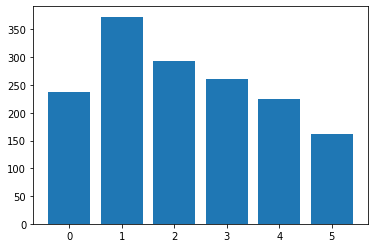

Counter({1: 373, 2: 293, 3: 261, 0: 237, 4: 225, 5: 162})
Counter({1: 1865, 2: 1465, 3: 1305, 0: 1185, 4: 1125, 5: 810})


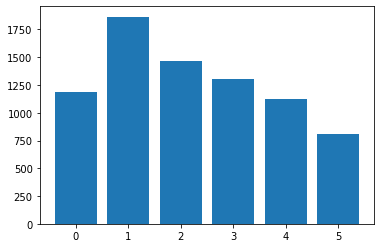

In [21]:
X_train, X_test, y_train_df, y_test_df = train_test_split(X, labels, test_size = 0.2, random_state = 12, stratify=y)
y_train = y_train_df.label.values
y_test = y_test_df.label.values
X_train, y_train = augment_data_no_dist_balance(X_train, y_train)

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 213412, stratify=y)
# X_train, y_train = augment_data(X_train, y_train)
# np.array(X_train).shape

#3 MLP Modelling

In [23]:
# networks
import torch
import torch.nn as nn

class RGB2HSV(nn.Module):
    def __init__(self):
        super(RGB2HSV, self).__init__()

    def rgb2hsv(self, input, epsilon=1e-5):
        assert(input.shape[1] == 3)
        r, g, b = input[:, 0], input[:, 1], input[:, 2]
        max_rgb, argmax_rgb = input.max(1)
        min_rgb, argmin_rgb = input.min(1)
        max_min = max_rgb - min_rgb + epsilon
        h1 = 60.0 * (g - r) / max_min + 60.0
        h2 = 60.0 * (b - g) / max_min + 180.0
        h3 = 60.0 * (r - b) / max_min + 300.0
        h = torch.stack((h2, h3, h1), dim=0).gather(dim=0, index=argmin_rgb.unsqueeze(0)).squeeze(0)
        s = max_min / (max_rgb + epsilon)
        v = max_rgb
        return torch.stack((h, s, v), dim=1)

    def forward(self,x):
        x = self.rgb2hsv(x)
        scores = x
        return scores
# ==========================
# ================================================================================
class MLP1(nn.Module):

    def __init__(self, input_size, output_size):
        super(MLP1, self).__init__()

        self.layer1 = nn.Linear(in_features=input_size, out_features=output_size, bias=True)

    def forward(self,x):
        x = self.layer1(x)
        scores = x
        return scores
# ================================================================================
class MLP3(nn.Module):

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(MLP3, self).__init__()

        self.layer1 = nn.Linear(in_features=input_size,    out_features=hidden_size_1, bias=True)
        self.layer2 = nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2, bias=True)
        self.layer3 = nn.Linear(in_features=hidden_size_2, out_features=output_size,   bias=True)

    def forward(self, x):
        x = x.view(-1,self.layer1.in_features)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        scores = x
        return scores
# ================================================================================
class CNN(nn.Module):

    def __init__(self, channel_size):
        super(CNN, self).__init__()

        # Conv2d parameters
        in_channels       = 3
        conv_kernel_size  = 3
        conv_stride       = 1
        conv_padding      = 1
        bias              = True

        # MaxPool2d parameters
        pool_kernel_size  = 2
        pool_stride       = 2
        pool_padding      = 0
        
        # block 1
        self.layer1a = nn.Conv2d(in_channels=in_channels,    out_channels=channel_size*1, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.layer1b = nn.Conv2d(in_channels=channel_size*1, out_channels=channel_size*1, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool1   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

        # block 2
        self.layer2a = nn.Conv2d(in_channels=channel_size*1, out_channels=channel_size*2, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.layer2b = nn.Conv2d(in_channels=channel_size*2, out_channels=channel_size*2, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool2   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

        # block 3
        self.layer3a = nn.Conv2d(in_channels=channel_size*2, out_channels=channel_size*4, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.layer3b = nn.Conv2d(in_channels=channel_size*4, out_channels=channel_size*4, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool3   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

        # block 4
        self.layer4a = nn.Conv2d(in_channels=channel_size*4, out_channels=channel_size*8, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool4   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

    def forward(self, x):
        # block 1
        x = self.layer1a(x)
        x = torch.relu(x)
        x = self.layer1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2
        x = self.layer2a(x)
        x = torch.relu(x)
        x = self.layer2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3
        x = self.layer3a(x)
        x = torch.relu(x)
        x = self.layer3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        # block 4
        x = self.layer4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        scores = x
        return scores
# ================================================================================
# class RNN(nn.Module):

#     def __init__(self, vocab_size, hidden_size):
#         super(RNN, self).__init__()

#         # layers
#         self.layer1 = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_size)
#         self.layer2 = nn.LSTM(hidden_size, hidden_size)
        
#     def forward(self, word_seq, h_init, c_init):
#         g_seq                    = self.layer1(word_seq)
#         h_seq, (h_final,c_final) = self.layer2(g_seq, (h_init, c_init))
#         return h_seq, h_final, c_final
# ================================================================================
class Combined_CNN_MLP3(nn.Module):

    def __init__(self, color_space, cnn, mlp3, COLOR_TRANS = True):
        super(Combined_CNN_MLP3, self).__init__()
        self.color_space = color_space
        self.cnn  = cnn
        self.mlp3 = mlp3
        self.color_trans = COLOR_TRANS

    def forward(self, x):
        if self.color_trans: x = self.color_space(x)
        x = self.cnn(x)
        x = self.mlp3(x)
        scores = x
        return scores
# ================================================================================
# class Combined_RNN_MLP1(nn.Module):

#     def __init__(self, rnn, mlp1):
#         super(Combined_RNN_MLP1, self).__init__()

#         self.rnn  = rnn
#         self.mlp1 = mlp1

#     def forward(self, word_seq, h_init, c_init):
#         h_seq, h_final, c_final = self.rnn(word_seq, h_init, c_init)
#         score_seq = self.mlp1(h_seq)
#         return score_seq, h_final, c_final
# ================================================================================

In [24]:
def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    return 100*num_matches.float()/num_data  

def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

def eval_on_test_set(test_data, test_label, net, mean, std, bs, device):

    running_error=0
    running_acc = 0
    num_batches=0

    for i in range(0,100,bs):

        minibatch_data =  test_data[i:i+bs].to(device)
        minibatch_label = test_label[i:i+bs].to(device)
        
        inputs = (minibatch_data - mean)/std

        scores= net( inputs ) 

        error = get_error( scores.detach() , minibatch_label)
        acc = get_accuracy( scores.detach() , minibatch_label)

        running_error += error.item()
        running_acc += acc.item()

        num_batches+=1

    total_error = running_error/num_batches
    total_acc = running_acc/num_batches
    # print(running_error, num_batches)
    print( 'error rate on test set =', total_error*100 ,'percent')
    print('accuracy =', total_acc)
    return total_error, total_acc

In [25]:
# # utilities
# import math

# def display_num_param(net):
#     nb_param = 0
#     for param in net.parameters():
#         nb_param += param.numel()
#     print('There are {} ({:.2f} million) parameters in this neural network'.format(nb_param, nb_param/1e6))



# def get_error( scores , labels ):
#     bs=scores.size(0)
#     predicted_labels = scores.argmax(dim=1)
#     indicator = (predicted_labels == labels)
#     num_matches=indicator.sum()
#     return 1-num_matches.float()/bs   

# def get_accuracy(scores, labels):
#     num_data = scores.size(0)
#     predicted_labels = scores.argmax(dim=1)
#     indicator = (predicted_labels == labels)
#     num_matches = indicator.sum()
#     return 100*num_matches.float()/num_data

# def normalize_gradient(net):
#     grad_norm_sq=0
#     for p in net.parameters():
#         grad_norm_sq += p.grad.data.norm()**2
#     grad_norm=math.sqrt(grad_norm_sq)
#     if grad_norm<1e-4:
#         net.zero_grad()
#         print('grad norm close to zero')
#     else:    
#         for p in net.parameters():
#              p.grad.data.div_(grad_norm)
#     return grad_norm

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# from utils.utilities import display_num_param
# from utils.utilities import get_accuracy
# from utils.utilities import normalize_gradient
# from mods.networks import MLP1
# from mods.networks import MLP3
# from mods.networks import CNN
# from mods.networks import RNN
# from mods.networks import Combined_CNN_MLP3
# from mods.networks import Combined_RNN_MLP1

# ================================================================================
# mimic labs_lecture08: Lab04: VGG architecture
def create_net1(num_class=6):
    # parameters
    channel_size  = 64
    input_size    = 4608
    hidden_size_1 = 4608*2
    hidden_size_2 = 4608*2
    output_size   = num_class

    # modules
    rgb_to_hsv = RGB2HSV()
    cnn  = CNN(channel_size=channel_size) # 4608
    mlp3 = MLP3(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size)
    net1 = Combined_CNN_MLP3(color_space = rgb_to_hsv, cnn=cnn, mlp3=mlp3)
    return net1

# # mimic labs_lecture10: Lab02: LSTM architecture
# def create_net2():
#     # parameters
#     vocab_size  = 10000
#     hidden_size = 300
#     input_size  = hidden_size
#     output_size = vocab_size

#     # modules
#     rnn  = RNN(vocab_size=vocab_size, hidden_size=hidden_size)
#     mlp1 = MLP1(input_size=input_size, output_size=output_size)
#     net2 = Combined_RNN_MLP1(rnn=rnn, mlp1=mlp1)

#     # initialize weights
#     net2.rnn.layer1.weight.data.uniform_( -0.1, 0.1)
#     net2.mlp1.layer1.weight.data.uniform_(-0.1, 0.1)
#     return net2
# ================================================================================
def train_net1(net1, X_train, y_train, X_test, y_test, device, optimizer_func = torch.optim.SGD):
    log = {
        "train_loss": [],
        "train_error": [],
        "train_accuracy": [],
        "test_error": [],
        "test_accuracy": [],
    }
    # parameters
    epoch_count      = 50
    batch_size       = 64
    learning_rate    = 0.00001

    X_train = X_train.view(-1, 3, 50, 50)
    X_test = X_test.view(-1, 3, 50, 50)
    train_data_count = X_train.shape[0]
    mean = X_train.mean().to(device)
    std = X_train.std().to(device)

    # objects
    criterion = nn.CrossEntropyLoss()

    # training loop
    start = time.time()
    for epoch in range(epoch_count):

        # statistics
        running_loss=0
        running_error=0
        running_accuracy = 0
        num_batches=0

        # objects - new optimizer each epoch

        optimizer = optimizer_func(net1.parameters(), lr=learning_rate)

        # sample inputs randomly
        shuffled_indices = torch.randperm(train_data_count)

        # minibatch loop
        for count in range(0, train_data_count, batch_size):

            # reset gradients
            optimizer.zero_grad()

            # create minibatch
            indices = shuffled_indices[count:count+batch_size].to(device)
            minibatch_data =  X_train[indices].to(device)
            minibatch_label =  y_train[indices].to(device)
            
            # forward pass
            inputs = (minibatch_data - mean) / std
            inputs.requires_grad_()
            scores = net1(inputs)
            loss   = criterion(scores, minibatch_label)

            # backward pass
            loss.backward()
            optimizer.step()

            # statistics (with detach to prevent accumulation)
            running_loss += loss.detach().item()
            error = get_error( scores.detach() , minibatch_label)
            acc = get_accuracy(scores.detach() , minibatch_label)
            running_error += error.item()
            running_accuracy += acc.item()
            num_batches +=1


        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        total_acc = running_accuracy/num_batches
        log["train_loss"].append(total_loss)
        log["train_error"].append(total_error)
        log["train_accuracy"].append(total_acc)
    
        print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        print('accuracy =', total_acc)
        print(' ')

        test_error,test_acc = eval_on_test_set(X_test, y_test, net1, mean, std, batch_size,device=device)

        log["test_error"].append(test_error)
        log["test_accuracy"].append(test_acc)
        print("="*50)

        if test_acc > 37: break
    return log

        
# def train_net2(net2, train_data):
#     # parameters
#     epoch_count      = 100
#     batch_size       = 20
#     learning_rate    = 5
#     train_data_count = train_data.shape[0]
#     seq_length       = 35

#     # objects
#     criterion = nn.CrossEntropyLoss()

#     # training loop
#     start = time.time()
#     for epoch in range(epoch_count):

#         # statistics
#         running_loss     = 0
#         running_accuracy = 0
#         num_batches      = 0

#         # objects - new optimizer each epoch
#         optimizer = torch.optim.SGD(net2.parameters(), lr=learning_rate)

#         # initialize weights
#         h = torch.zeros(1, batch_size, net2.rnn.layer1.embedding_dim,dtype=torch.float)
#         c = torch.zeros(1, batch_size, net2.rnn.layer1.embedding_dim,dtype=torch.float)

#         # minibatch loop
#         for count in range(0, train_data_count-seq_length, seq_length):

#             # reset gradients
#             optimizer.zero_grad()

#             # create minibatch
#             minibatch_data  = train_data[count  :count+seq_length]
#             minibatch_label = train_data[count+1:count+seq_length+1]

#             # detach to prevent backpropagating all the way to the beginning, then start tracking gradients on h and c
#             h = h.detach()
#             c = c.detach()
#             h = h.requires_grad_()
#             c = c.requires_grad_()

#             # forward pass
#             inputs = minibatch_data.to(torch.int64)
#             scores, h, c = net2(inputs, h, c)
#             scores          = scores.view(         batch_size*seq_length, net2.rnn.layer1.num_embeddings)
#             minibatch_label = minibatch_label.view(batch_size*seq_length).to(torch.int64)
#             loss   = criterion(scores, minibatch_label)

#             # backward pass
#             loss.backward()
#             normalize_gradient(net2)
#             optimizer.step()

#             # statistics (with detach to prevent accumulation)
#             running_loss += loss.detach().item()
#             accuracy = get_accuracy(scores.detach(), minibatch_label)
#             running_accuracy += accuracy.item()
#             num_batches +=1
#             print("completed={}, running_loss={}, accuracy={}, running_accuracy={}".format(count/train_data_count, running_loss, accuracy, running_accuracy))
#             if count%(batch_size*2) == 0:
#                 break

#         # statistics
#         total_loss     = running_loss/num_batches
#         total_accuracy = running_accuracy/num_batches
#         elapsed        = (time.time()-start)/60
#         print("Epoch={}, Train loss={}, Train accuracy={}".format(epoch+1, total_loss, total_accuracy))
#         if epoch%2 == 0:
#             break


# ================================================================================
def case1(X_train, y_train, X_test, y_test, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    net = create_net1(num_class=6).to(device)
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    log = train_net1(net, X_train, y_train, X_test, y_test,  device = device, optimizer_func = torch.optim.SGD)
    return net,log

# ================================================================================
def case2(X_train, y_train, X_test, y_test, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    net = create_net1(num_class=6).to(device)
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    log = train_net1(net, X_train, y_train, X_test, y_test,  device = device,  optimizer_func = torch.optim.Adam)
    return net,log

# Training 

In [27]:
# case1_net = case1(X_train, y_train, X_test, y_test)

In [ ]:
case2_net, log = case2(X_train, y_train, X_test, y_test)


# Plotting & Analysis

In [ ]:
index_df = y_test_df.copy()
index_df["file_idx"] = index_df.filename.str.split('.').str[0].astype(int)
index_df = index_df.reset_index()
index_df


In [ ]:
# def modify_label(df, image_idx, label):
#     file_name = str(image_idx)+".jpg"
#     display(df.loc[df["filename"]==file_name])
#     df.loc[df["filename"]==file_name, "label"] = label
#     display(df.loc[df["filename"]==file_name])


# """ Dont run this unless you comfirm to modify label
# """
# modify = True
# if modify:
#     modify_label(labels, idx, 1)

In [ ]:
from random import randint
# choose a picture at random
idx=randint(0, len(X_test))
# f_idx = np.random.choice(np.sort(index_df.file_idx)[-50:])
# idx = index_df[index_df.file_idx==f_idx].index[0]

# idx=randint(0, len(X))

# idx = np.where(y_test_df.index.values == idx)
label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)
print(idx)
im=X_test[idx].astype(np.uint8)

# data_sourcing = "test" if np.isin(idx,y_test_df.index) else "train"

# X_train, X_test, y_train, y_test
# diplay the picture
image_label = f"label index: {y_test[idx]}; label is {label[y_test[idx]]}; image name is {y_test_df.reset_index().iloc[idx,1]}"
image_utils().plot_image(im,title=image_label, figsize=(5,5))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
im=X_test[idx].astype(np.uint8)
im = torch.from_numpy(np.array(im).astype(np.float32)).to(device)
X_train_ = torch.from_numpy(np.array(X_train).astype(np.float32))
X_train_ = X_train_.view(-1, 3, 50, 50)
mean= X_train_.mean()
std= X_train_.std()
# # send to device, rescale, and view as a batch of 1 
# im = im.to(device)
im= (im-mean) / std

im=im.view(1,3,50,50)

# # feed it to the net and display the confidence scores

scores =  case2_net(im) 
probs= torch.softmax(scores, dim=1)
image_utils().show_prob_pimples(probs.cpu())

In [ ]:
from random import randint
# choose a picture at random
# idx=randint(0, len(X_test))
# f_idx = np.random.choice(np.sort(index_df.file_idx)[-50:])
# idx = index_df[index_df.file_idx==f_idx].index[0]

idx=randint(0, len(X))

# idx = np.where(y_test_df.index.values == idx)
label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)
print(idx)
# im=X_test[idx].astype(np.uint8)
im=X[idx]

data_sourcing = "test" if np.isin(idx,y_test_df.index) else "train"

# X_train, X_test, y_train, y_test
# diplay the picture
# image_label = f"label index: {y_test[idx]}; label is {label[y_test[idx]]}; image name is {y_test_df.reset_index().iloc[idx,1]}"
image_label = f"image_idx={labels.iloc[idx].filename}; label index: {y[idx]}; label is {label[y[idx]]}; from {data_sourcing}"
image_utils().plot_image(im,title=image_label, figsize=(5,5))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
im=X[idx]
im = torch.from_numpy(np.array(im).astype(np.float32)).to(device)
X_train_ = torch.from_numpy(np.array(X_train).astype(np.float32))
X_train_ = X_train_.view(-1, 3, 50, 50)
mean= X_train_.mean()
std= X_train_.std()
# # send to device, rescale, and view as a batch of 1 
# im = im.to(device)
im= (im-mean) / std

im=im.view(1,3,50,50)

# # feed it to the net and display the confidence scores

scores =  case2_net(im) 
probs= torch.softmax(scores, dim=1)
image_utils().show_prob_pimples(probs.cpu())

In [ ]:
import plotly.express as px
log_df = pd.DataFrame.from_dict(log)
log_df = log_df.reset_index()
fig = px.line(log_df.iloc[1:], x="index", y="train_loss")
fig.show()
type = "accuracy"
df1 = log_df[['index', f"train_{type}", f"test_{type}"]].melt(id_vars=['index'], var_name='log_type')
fig = px.line(df1, x="index", y="value", color='log_type')
fig.show()

type = "error"
df1 = log_df[['index', f"train_{type}", f"test_{type}"]].melt(id_vars=['index'], var_name='log_type')
fig = px.line(df1, x="index", y="value", color='log_type')
fig.show()

In [ ]:
throw(errdsvmfopsejk)

## 4. CNN Modelling

In [ ]:
from os import listdir, rename
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

In [ ]:
# !pip3 install scikit-image

In [ ]:
print(os.getcwd())
# !pip install gdown
# !gdown --id 1zIu388ksAxVp4IQ4UOS1cnfK4n6VYhOd --output labels.csv
!wget "https://raw.githubusercontent.com/simasuiyuan/CS5242/zhunhung_dev/labels.csv"
labels = pd.read_csv('labels.csv')

In [ ]:
labels.head()

In [ ]:
labels.shape

### Helper Functions

In [ ]:
def load_images(labels):
    X = []
    y = []
    for row in labels.itertuples():
        print(row)
        img_path = join('dataset', row.filename)
        img = np.asarray(Image.open(img_path))
        
        # Keep squares for now
        if img.shape[0] == img.shape[1]:
            y.append(row.label)
            X.append(img)
    return X, y


In [ ]:
def augment_data(X_train, y_train):
    final_X_train = []
    final_y_train = []
    for i in range(len(X_train)):
        final_X_train.append(X_train[i])
        final_X_train.append(rotate(X_train[i], angle=45, mode = 'wrap'))
        final_X_train.append(np.fliplr(X_train[i]))
        final_X_train.append(np.flipud(X_train[i]))
        final_X_train.append(random_noise(X_train[i],var=0.2**2))
        
        final_y_train += [y_train[i]] * 5
    return final_X_train, final_y_train

In [ ]:
def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    return 100*num_matches.float()/num_data  

def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

def eval_on_test_set(test_data, test_label, net, mean, std, bs, device):

    running_error=0
    running_acc = 0
    num_batches=0

    for i in range(0,100,bs):

        minibatch_data =  test_data[i:i+bs].to(device)
        minibatch_label = test_label[i:i+bs].to(device)
        
        inputs = (minibatch_data - mean)/std

        scores= net( inputs ) 

        error = get_error( scores.detach() , minibatch_label)
        acc = get_accuracy( scores.detach() , minibatch_label)

        running_error += error.item()
        running_acc += acc.item()

        num_batches+=1

    total_error = running_error/num_batches
    total_acc = running_acc/num_batches
    print(running_error, num_batches)
    print( 'error rate on test set =', total_error*100 ,'percent')
    print('accuracy =', total_acc)
    return total_error, total_acc

In [ ]:
X, y = load_images(labels)

In [ ]:
Counter(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13, stratify=y)

In [ ]:
X_train, y_train = augment_data(X_train, y_train)

### Training

In [ ]:
import torch

In [ ]:
class convnet(torch.nn.Module):

    def __init__(self, input_channel, hidden_layer, num_class):

        super(convnet, self).__init__()
      
        self.conv1a = torch.nn.Conv2d(input_channel, hidden_layer,  kernel_size=5, padding=1 )
        self.pool1a  = torch.nn.MaxPool2d(2,2)
        self.conv1b = torch.nn.Conv2d(hidden_layer,  hidden_layer,  kernel_size=5, padding=1 )
        self.pool1b  = torch.nn.MaxPool2d(2,2)
        
        self.linear1 = torch.nn.Linear(12100, num_class)

    def forward(self, x):
        x = self.conv1a(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1a(x)
        x = self.conv1b(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1b(x)
        
        x = x.view(-1, 12100)
        x = self.linear1(x)
        
        return x

In [ ]:
def train_network(X_train, y_train, X_test, y_test):
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    X_train = X_train.view(-1, 3, 50, 50)
    X_test = X_test.view(-1, 3, 50, 50)
    
    my_lr = 0.01
    criterion = torch.nn.CrossEntropyLoss()
    bs = 128
    num_class = 6

    net = convnet(3, 100, num_class)
    mean = X_train.mean()
    std = X_train.std()
    num_train_data = X_train.size()[0]
    
    for epoch in range(5):
        # create a new optimizer at the beginning of each epoch: give the current learning rate.   
        optimizer=torch.optim.Adam( net.parameters() , lr=my_lr )

        # set the running quatities to zero at the beginning of the epoch
        running_loss=0
        running_error=0
        running_acc = 0
        num_batches=0

        # set the order in which to visit the image from the training set
        shuffled_indices = torch.randperm(num_train_data)

        for count in range(0,num_train_data,bs):

            # Set the gradients to zeros
            optimizer.zero_grad()

            # create a minibatch       
            indices = shuffled_indices[count:count+bs]
            minibatch_data =  X_train[indices]
            minibatch_label =  y_train[indices]


            # normalize the minibatch (this is the only difference compared to before!)
            inputs = (minibatch_data - mean)/std

            # tell Pytorch to start tracking all operations that will be done on "inputs"
            inputs.requires_grad_()

            # forward the minibatch through the net 
            scores=net( inputs ) 

            # Compute the average of the losses of the data points in the minibatch
            loss =  criterion( scores , minibatch_label) 

            # backward pass to compute dL/dU, dL/dV and dL/dW   
            loss.backward()

            # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
            optimizer.step()


            # START COMPUTING STATS

            # add the loss of this batch to the running loss
            running_loss += loss.detach().item()

            # compute the error made on this batch and add it to the running error       
            error = get_error( scores.detach() , minibatch_label)
            acc = get_accuracy(scores.detach() , minibatch_label)
            running_error += error.item()
            running_acc += acc.item()

            num_batches+=1        


        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        total_acc = running_acc/num_batches


        print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        print('accuracy =', total_acc)
        print(' ')

    eval_on_test_set(X_test, y_test, net, mean, std, bs)


In [ ]:
train_network(X_train, y_train, X_test, y_test)

## 5. Analysis of Results

In [ ]:
# line chart 
# confusion matrix



# # choose a picture at random
# idx=randint(0, 10000-1)
# im=test_data[idx]

# # diplay the picture
# utils.show(im)

# # send to device, rescale, and view as a batch of 1 
# im = im.to(device)
# im= (im-mean) / std
# im=im.view(1,3,32,32)

# # feed it to the net and display the confidence scores
# scores =  net(im) 
# probs= torch.softmax(scores, dim=1)
# utils.show_prob_cifar(probs.cpu())



# from sklearn.metrics import confusion_matrix
# confusion_matrix(actual_labels, predicted_labels)

## 

In [ ]:
hello

## Future Development

In [ ]:
dsvdsv